# 测试CAFNOVAE模型对5天预报的背景场做一次同化后继续做10天预报的结果


In [1]:
%load_ext autoreload
%autoreload 2

## 基本参数设置

In [2]:
# Depending on your combination of package versions, this can raise a lot of TF warnings... 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch
from pathlib import Path
import pickle
import sys
sys.path.append('../')
from src.utils.score import *
from src.utils.plot import plot_iter_result, plot_increment
from collections import OrderedDict
from src.inference.autoregressive_inference import autoregressive_inference_cafnovae_midrange
from src.models.prednn_module import PredNNLitModule # 预报模型
from src.models.cafnovae_module import CAFNOVAELitModule # 同化模型

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

设置数据路径，模型预报步长，数据模式，观测分布比例，观测误差

配置同化和预报的基本参数：
- 同化窗口（assimilation window）: daw
- 观测间隔时间：dt_obs

In [4]:
data_dir = '/dataset/era5'
xb_dir = '/dataset/background_dtmodel6_predlen120'
obs_dir = '/dataset/observation_err0.015'
obs_partial_mask_dir = '/dataset/obs_partial_mask'
# obs_single_mask_dir = '/dataset/obs_single_mask'
pretrain_dir = '/dataset/pred_model'
init_time = 120
dtmodel = 6
dt_obs = 3
daw = 12
mode = 'test'
obs_partial = 0.5
obs_single = False
obserr_level = 0.015
prediction_length = dtmodel + 24 * 15
DECORRELATION_TIME = dt_obs * 36
out_iter = 5

## 读取测试数据集

从.nc文件中读取数据，为后续预测技巧的验证提供基础数据支撑

In [5]:
# Load the validation subset of the data: 2018
# 读取再分析数据作为验证真值
z500_valid = load_test_data(f'{data_dir}/{mode}', 'z', years=slice('2018'))
valid = xr.merge([z500_valid])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 8760)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 ...
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [6]:
# 读取均值、方差、经纬度网格数据
with open(Path(f'{data_dir}')/f'scaler.pkl', 'rb') as f:
    item = pickle.load(f)
    lon = item['lon']
    lat = item['lat']
    mean = item['mean']
    std = item['std']
    f.close()

mean, std

(54108.31062925485, 3352.3980519318557)

In [7]:
# Load the validation subset of the data: 2017 and 2018
# 读取观测数据
obs = xr.open_mfdataset(f'{obs_dir}/{mode}/observations_2018_err{obserr_level}.nc', combine='by_coords')
obs = (obs - mean) / std

In [8]:
valid = valid.sel(time=obs['time'])
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 2880)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 ...
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2018-01-06 ... 2018-12-31T21:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(2880, 32, 64), meta=np.ndarray>
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [9]:
start_id = int((obs['time'][0]-valid["time"][0]).values.astype('timedelta64[h]') / np.timedelta64(1, 'h'))

In [10]:
start_id

0

In [11]:
# Load the validation subset of the data: 2017 and 2018
# 读取观测数据
xbs = xr.open_mfdataset(f'{xb_dir}/{mode}/*.nc', combine='by_coords').sel(init_time=-init_time)
xbs = (xbs - mean) / std
xbs

<xarray.Dataset>
Dimensions:    (time: 2880, level: 1, lat: 32, lon: 64)
Coordinates:
    init_time  int64 -120
  * time       (time) datetime64[ns] 2018-01-06 ... 2018-12-31T21:00:00
  * level      (level) int32 500
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z          (time, level, lat, lon) float32 dask.array<chunksize=(2880, 1, 32, 64), meta=np.ndarray>

## 加载训练好的模型参数

In [12]:
# 加载预训练预报模型
module = PredNNLitModule.load_from_checkpoint(f'{pretrain_dir}/best_lead{dtmodel}h.ckpt')
afnonet = module.net.to(device).eval()

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [13]:
# 加载预训练预报模型
module = CAFNOVAELitModule.load_from_checkpoint(f'/pretrainmodel/epoch_020.ckpt')
cafnovae = module.net.to(device).eval()

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


## 构建预报结果

使用AFNONet结合4DVar做同化进行，将预测结果写入nc文件中

- 归一化观测误差：noise
- 场变量维度：N
- 背景误差协方差矩阵：B
- 观测误差协方差矩阵：R

In [14]:
obs['z'].values.shape

(2880, 1, 32, 64)

In [15]:
noise = obserr_level * mean / std
obs_value = obs['z'].values
N = obs_value.shape[-1]*obs_value.shape[-2]
# B = noise ** 2 * np.eye(N, N)
B_inv = 1/(1e-2) * np.eye(N, N) # 背景误差协方差求逆
R_inv = 1/(noise ** 2) * np.eye(N, N) # 观测误差协方差求逆
# 构建观测算子（仅支持常规观测）
obs_masks = np.ones((np.size(obs_value, 0), N))
for i in range(0, np.size(obs_value, 0)):
    obs_mask = np.zeros(N)
    if obs_single:
        obs_mask[0] = 1
    else:
        obs_mask[:int(obs_partial*obs_mask.shape[0])] = 1
    np.random.shuffle(obs_mask)
    obs_masks[i] = obs_mask
obs_masks = np.reshape(obs_masks, (obs_value.shape))

In [16]:
n_samples_per_year = len(valid['z'])//dt_obs
n_samples = n_samples_per_year - prediction_length
stop = n_samples
ics = np.arange(start_id, stop, DECORRELATION_TIME)
n_ics = len(ics)

valid_loss = []
acc = []
seq_pred = []
seq_real = []

In [18]:
fcs = []
val_rmse, val_acc, val_mae = [], [], []
for i, ic in enumerate(ics):
    fc, rmse, acc, mae = autoregressive_inference_cafnovae_midrange(ic, 
                                                        start_id,
                                                        mean, 
                                                        std, 
                                                        valid, 
                                                        xbs['z'].values[ic],
                                                        obs['z'].values, 
                                                        afnonet,
                                                        cafnovae,
                                                        dtmodel, 
                                                        daw,
                                                        dt_obs, 
                                                        prediction_length, 
                                                        obs_masks, 
                                                        device)
    fcs.append(fc)
    val_rmse.append(rmse)
    val_acc.append(acc)
    val_mae.append(mae)
    del fc, rmse, acc, mae

In [19]:
fc_iter = xr.merge(fcs)
# xb_iter = xr.merge(xbs_)
val_rmse = np.mean(np.concatenate(val_rmse, 0), axis=0)
val_acc = np.mean(np.concatenate(val_acc, 0), axis=0)
val_mae = np.mean(np.concatenate(val_mae, 0), axis=0)

## 统计及可视化分析

### 统计RMSE与ACC

In [20]:
xr_rmse = [xr.DataArray(
                        val_rmse[:,0],
                        dims=['Lead Time'],
                        coords={
                            'Lead Time': fc_iter.lead_time.values,
                        },
                        name='z'
                    )]
xr_rmse = xr.merge(xr_rmse)

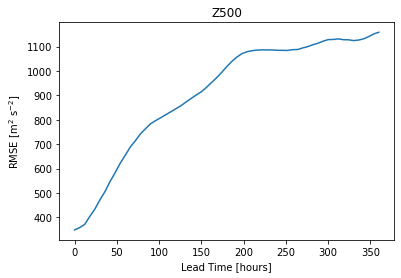

In [21]:
plot_iter_result(xr_rmse, 'z', 'Lead Time', 'RMSE', 'Z500', ' [hours]', ' [m$^2$ s$^{-2}$]', f'midrange_rmse_cafnovae_obserr0.015_obssingle' if obs_single else f'midrange_rmse_cafnovae_obserr0.015_obspartial{obs_partial}')

In [22]:
xr_acc = [xr.DataArray(
                        val_acc[:,0],
                        dims=['Lead Time'],
                        coords={
                            'Lead Time': fc_iter.lead_time.values,
                        },
                        name='z'
                    )]
xr_acc = xr.merge(xr_acc)

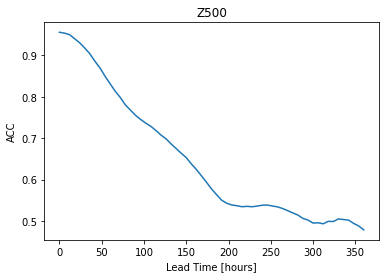

In [23]:
plot_iter_result(xr_acc, 'z', 'Lead Time', 'ACC', 'Z500', ' [hours]', '', f'midrange_acc_cafnovae_obserr0.015_obssingle' if obs_single else f'midrange_acc_cafnovae_obserr0.015_obspartial{obs_partial}')

In [24]:
xr_mae = [xr.DataArray(
                        val_mae[:,0],
                        dims=['Lead Time'],
                        coords={
                            'Lead Time': fc_iter.lead_time.values,
                        },
                        name='z'
                    )]
xr_mae = xr.merge(xr_mae)

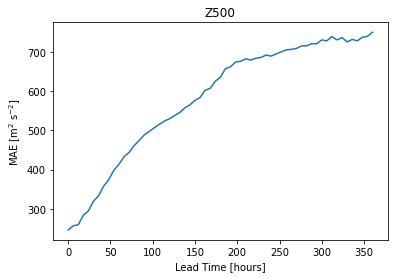

In [25]:
plot_iter_result(xr_mae, 'z', 'Lead Time', 'MAE', 'Z500', ' [hours]', ' [m$^2$ s$^{-2}$]', f'midrange_mae_cafnovae_obserr0.015_obssingle' if obs_single else f'midrange_mae_cafnovae_obserr0.015_obspartial{obs_partial}')

### 可视化背景、分析与增量

In [ ]:
plot_increment(valid, xb_iter, fc_iter, f'midrange_inc_cafnovae_obserr0.015_obssingle' if obs_single else f'midrange_inc_cafnovae_obserr0.015_obspartial{obs_partial}')